In [1]:
import re
import sys
import os
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy import cluster

from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.signal import find_peaks

import PCprophet.io_ as io
import PCprophet.generate_features_allbyall as gf

In [2]:
infile = "..\\data\\SEC_pilot_HEK\\SEC_pilot_HEK_min_5_frac.txt"
#infile = "..\\test\\test_frac.txt"


# Outlier detection

Simple z-scoring does not work because an outlier with the same intensitiy as a peak of a chromatogram would have the same z-score as that peak

Idea: 
- look for sharp increases followed by sharp decreases by computing difference between value and previous value and then multiplying neighboring values
- Sharp increases followed by sharp decreases will lead to high negative values -> detect those using z-scoring

Pitfall: 
- This method requires padding the chromatogram -> method is blind to outliers in the first and last fractions

In [3]:
prot_dict = io.read_txt(path=infile)
prot_dict_filtered = gf.remove_outliers(prot_dict, threshold=-7)

Number of analyzed genes in ..\data\SEC_pilot_HEK\SEC_pilot_HEK_min_5_frac.txt: 6692
Removed 1 empty or invalid keys from prot_dict.


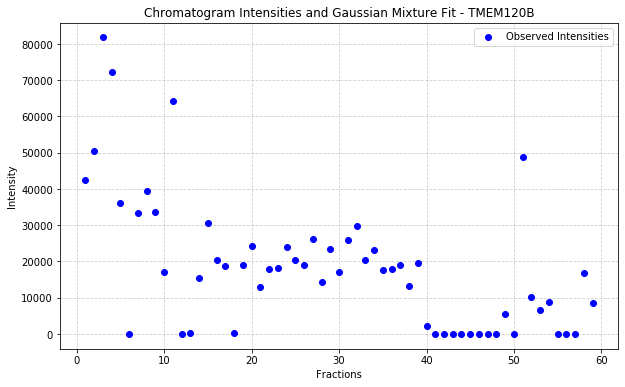

In [11]:
prot_dict_vis = prot_dict_filtered

protein = list(prot_dict_vis.keys())[1]
fractions = np.arange(1, len(prot_dict_vis[protein]) + 1)
intensities = np.array(prot_dict_vis[protein])

plt.figure(figsize=(10, 6))

# Plot observed intensities
plt.scatter(fractions, intensities, color='blue', label='Observed Intensities', zorder=5)

# Customize plot
plt.title(f"Chromatogram Intensities and Gaussian Mixture Fit - {protein}")
plt.xlabel("Fractions")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [12]:
prot_dict_smooth = gf.clean_prot_dict(prot_dict_filtered)
prot_dict_scaled = gf.min_max_scale_prot_dict(prot_dict=prot_dict_smooth)

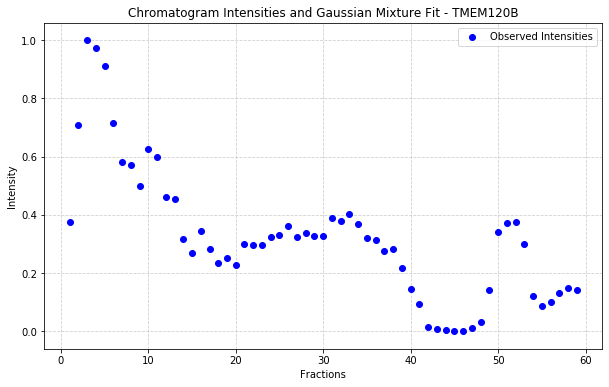

In [13]:
prot_dict_vis = prot_dict_scaled

fractions = np.arange(1, len(prot_dict_vis[protein]) + 1)
intensities = np.array(prot_dict_vis[protein])

plt.figure(figsize=(10, 6))

plt.scatter(fractions, intensities, color='blue', label='Observed Intensities', zorder=5)

plt.title(f"Chromatogram Intensities and Gaussian Mixture Fit - {protein}")
plt.xlabel("Fractions")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# PrInCE - derived python code

In [14]:
def visualize_fit(protein, intensities, gmm):
    """
    Visualize the original chromatogram with the Gaussian fits and centers.

    Parameters:
        intensities (np.ndarray): The original elution profile.
        gmm (dict): Dictionary containing the Gaussian fit results,
                           including coefficients and fitted curve.
    """
    # Generate indices for plotting
    indices = np.arange(len(intensities))

    # Plot original intensities
    plt.figure(figsize=(10, 6))
    plt.scatter(indices, intensities, label="Original Profile", color="blue")

    # Plot the fitted Gaussian curve, if available
    if gmm.get('fit_curve') is not None:
        plt.plot(indices, gmm['fit_curve'], label="Fitted Curve", color="red", linestyle="-")

    # Highlight Gaussian centers (mu) with vertical dashed lines
    coefs = gmm.get('coefs')
    if coefs and 'mu' in coefs:
        mu_values = coefs['mu']
        for mu in mu_values:
            plt.axvline(x=mu, color="green", linestyle="dashed", label="Center (mu)" if mu == mu_values[0] else None)

    # Configure plot details
    plt.xlabel("Fraction")
    plt.ylabel("Intensity")
    plt.title(f"Chromatogram with Gaussian Fit and Centers - {protein}")
    plt.legend()
    plt.grid(True)
    plt.show()


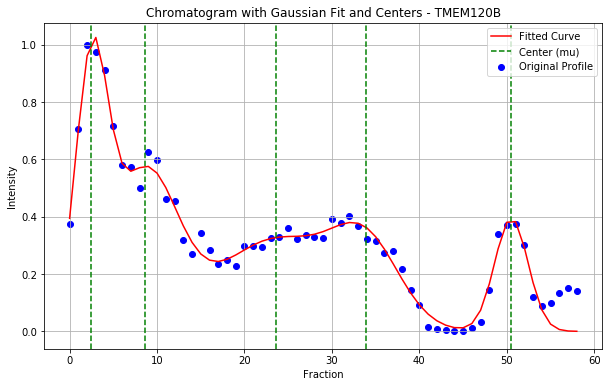

In [15]:
fractions = np.arange(1, len(prot_dict_scaled[protein]) + 1)
intensities = np.array(prot_dict_scaled[protein])

gmm = gf.choose_gaussians(intensities, max_gaussians=5, filter_gaussians_height=0.05, filter_gaussians_variance_min=0)

# Call the function to visualize
visualize_fit(protein=protein, intensities=intensities, gmm=gmm)